<i>DISCLAIMER:<br>
Bellow code is only for informative purpose, i renounce any responsibility regarding this code and bellow trained model causing loss of money during trading on real market.</i>

# Stock price prediction : NVDA

This page does following:

<b>1. Loading and preparation</b>
- Load data and libraries
- Normalize data based on linear scaling formula
- Split data to train and validation set (train 80%, validation 20%)
- Transform train and validation set into windows, each window has 6 rows (candles), first 5 rows represents formation the model is trained on, the 6th row is label (target price, the model will predict, this is highest price of following week). Windowed data are transformed to tensors for future model training<br>

<b>2. Fun part - model training</b>
- Entry price is High price of last candle in formation
- Model predicts high price of following week
- CNN + LSTM + DNN model is trained and compared to validation dataset used during training
- After model is trained, we let model predict prices on validation dataset<br>

<b>3. Result evaluation</b>
- New dataframe is created with predicted values, normalized data are reverted back to initial values
- We calculate  profit/loss per each trade on validation dataset and final balance is displayed
- Each trade is displayed in chart with target value, predicted value and entry price that trade was entered
- As the last step, prediction of the most recent stock data is made (please refer to page 03_Model_prediction

# 1. Loading and preparation

In [415]:
import tensorflow as tf
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt

print("Tensorflow version: ", tf.__version__)

path = "nvda_stock_raw.csv"

data = pd.read_csv(path)
data.tail()

Tensorflow version:  2.7.0


,Date,Open,High,Low,Close,EMA6,EMA12,EMA24,trades
30020,2022-06-06 00:00:00,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334,1201
30021,2022-06-13 00:00:00,160.000000,168.679993,153.279999,158.800003,176.168560,191.462513,210.243947,1201
30022,2022-06-20 00:00:00,164.750000,171.399994,158.529999,171.259995,174.766113,188.354434,207.125231,1201
30023,2022-06-27 00:00:00,173.119995,173.300003,143.919998,145.229996,166.327222,181.719905,202.173612,1201
30024,Month,141.750000,182.440002,140.550003,181.630005,NaN,NaN,NaN,1201


<b>Get data and plot chart</b>

In [416]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.title("AAPL close price")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [417]:
import csv
time_step = []

opens = []
highs = []
lows = []
closes = []
ema1 = []
ema2 = []
ema3 = []

new = []

final = []
with open(path) as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
   # next(reader)

    for row in reader:
        #print(row)
        
        time_step.append(row[0])
        opens.append(float(row[1]))
        highs.append(float(row[2]))
        lows.append(float(row[3]))
        closes.append(float(row[4]))
        ema1.append(row[5])
        ema2.append(row[6])
        ema3.append(row[7])

        
#Get series
series = np.array(closes[::])
time = np.array(time_step[::])

#Plot chart
#plt.figure(figsize=(10, 6))
#plot_series(time, series)
print("done")

done


Get data in dataframe and prepare for windowing, we will be getting windows of 4 candles each, thus we need to have dataframe divisible by 4

In [422]:
dicti = {'Date':time,
         'opens':opens,
         'high':highs,
         'low':lows,
         'close':closes,
         'ema6':ema1,
         'ema12':ema2,
         'ema24':ema3}

temp_old = pd.DataFrame(dicti)
temp_old.head(48)
temp_old.loc[temp_old['Date']=='2004-03-22 00:00:00']
temp_old.head(26)

,Date,opens,high,low,close,ema6,ema12,ema24
0,1999-01-18 00:00:00,0.437500,0.488281,0.388021,0.410156,,,
1,1999-01-25 00:00:00,0.442708,0.467448,0.395833,0.395833,,,
2,1999-02-01 00:00:00,0.395833,0.416667,0.360677,0.412760,,,
3,1999-02-08 00:00:00,0.415365,0.437500,0.372396,0.434896,,,
4,1999-02-15 00:00:00,0.442708,0.460938,0.393229,0.434896,,,
5,1999-02-22 00:00:00,0.442708,0.546875,0.414063,0.457031,0.42426199714342755,,
6,1999-03-01 00:00:00,0.468750,0.479167,0.411458,0.438802,0.42841628477686927,,
7,1999-03-08 00:00:00,0.427083,0.466146,0.416667,0.424479,0.42729134847517725,,
8,1999-03-15 00:00:00,0.434896,0.450521,0.420573,0.437500,0.430208106053698,,
9,1999-03-22 00:00:00,0.446615,0.447917,0.380208,0.436198,0.4319195032210775,,


In [423]:
for row in range(temp_old.shape[0]):
    if temp_old.iloc[row,4] == "":
        temp_old.iloc[row,4] = temp_old.iloc[row,3]
    if temp_old.iloc[row,5] == "":
        temp_old.iloc[row,5] = temp_old.iloc[row,4]
    if temp_old.iloc[row,6] == "":
        temp_old.iloc[row,6] = temp_old.iloc[row,5]
    if temp_old.iloc[row,7] == "":
        temp_old.iloc[row,7] = temp_old.iloc[row,6]
temp_old.head(25)       

,Date,opens,high,low,close,ema6,ema12,ema24
0,1999-01-18 00:00:00,0.437500,0.488281,0.388021,0.410156,0.410156,0.410156,0.410156
1,1999-01-25 00:00:00,0.442708,0.467448,0.395833,0.395833,0.395833,0.395833,0.395833
2,1999-02-01 00:00:00,0.395833,0.416667,0.360677,0.412760,0.41276,0.41276,0.41276
3,1999-02-08 00:00:00,0.415365,0.437500,0.372396,0.434896,0.434896,0.434896,0.434896
4,1999-02-15 00:00:00,0.442708,0.460938,0.393229,0.434896,0.434896,0.434896,0.434896
5,1999-02-22 00:00:00,0.442708,0.546875,0.414063,0.457031,0.42426199714342755,0.42426199714342755,0.42426199714342755
6,1999-03-01 00:00:00,0.468750,0.479167,0.411458,0.438802,0.42841628477686927,0.42841628477686927,0.42841628477686927
7,1999-03-08 00:00:00,0.427083,0.466146,0.416667,0.424479,0.42729134847517725,0.42729134847517725,0.42729134847517725
8,1999-03-15 00:00:00,0.434896,0.450521,0.420573,0.437500,0.430208106053698,0.430208106053698,0.430208106053698
9,1999-03-22 00:00:00,0.446615,0.447917,0.380208,0.436198,0.4319195032210775,0.4319195032210775,0.4319195032210775


<b>Reshuffle Dataset (if needed)</b>

since we are having windowed dataset, in order to do shuffle, we must reshaped data from 2D to 3D array, shuffle each window separately (so that structure is not broken) and than reshape 3D array back to 2D and create again dataframe

In [420]:
# from sklearn.utils import shuffle
# #3D reshaping
# temp = temp_old.values.reshape(-1,25,temp_old.shape[1])
# #shuffling
# sh = shuffle(temp)
# #sh = np.squeeze(sh)
# sh

array([[['2021-05-24 00:00:00', 152.125, 162.77499389648438, ...,
         '151.42398204430384', '146.94018276209988',
         '140.74399414615468'],
        ['2021-05-31 00:00:00', 162.6999969482422, 176.61000061035156,
         ..., '158.38355895184648', '151.3774625249619',
         '143.54707471211856'],
        ['2021-06-07 00:00:00', 175.71249389648438, 179.3925018310547,
         ..., '164.06039994886356', '155.51208405056875',
         '146.32350893046157'],
        ...,
        ['2021-10-25 00:00:00', 229.72999572753906, 257.0899963378906,
         ..., '229.01184544207698', '219.50727763642226',
         '203.31632965314094'],
        ['2021-11-01 00:00:00', 256.489990234375, 314.0, ...,
         '248.58560074824695', '231.5092332329222', '210.8526224019834'],
        ['Month', 301.489990234375, 346.4700012207031, ...,
         306.92999267578125, 306.92999267578125, 306.92999267578125]],

       [['2001-02-26 00:00:00', 2.1979169845581055, 2.2604169845581055,
         ..., 

In [421]:
# aa = sh.reshape(temp_old.shape[0],temp_old.shape[1])
# temp_old = pd.DataFrame(aa,columns=temp_old.columns)
# temp_old.tail(26)

,Date,opens,high,low,close,ema6,ema12,ema24
29999,Month,1.855833,1.890833,1.5925,1.605,1.605,1.605,1.605
30000,2004-11-08 00:00:00,1.454167,1.533333,1.4475,1.508333,1.3262908145077572,1.2759530691526206,1.335785204608215
30001,2004-11-15 00:00:00,1.493333,1.710833,1.484167,1.58,1.3987791654813535,1.3227295266545782,1.3553223916727855
30002,2004-11-22 00:00:00,1.585833,1.67,1.570833,1.655,1.4719851100266155,1.3738480566138385,1.3792965980501442
30003,2004-11-29 00:00:00,1.6675,1.75,1.585,1.7275,1.5449893534055903,1.4282560420352521,1.4071528671543747
30004,2004-12-06 00:00:00,1.735833,2.08,1.705,1.9425,1.658563822498744,1.5073704963731562,1.449980637400555
30005,2004-12-13 00:00:00,1.913333,2.071667,1.88,1.921667,1.7337361531533126,1.5711084168987837,1.4877155447916894
30006,2004-12-20 00:00:00,1.944167,1.974167,1.854167,1.9225,1.7876686849109704,1.625168662653604,1.5224983023527634
30007,2004-12-27 00:00:00,1.949167,1.973333,1.885,1.963333,1.8378584922716996,1.6771939469643606,1.557765079018424
30008,2005-01-03 00:00:00,2.031667,2.06,1.808333,1.835833,1.8372797668949465,1.7015999479626227,1.5800105089731953


Get dataframe divisible by 25, since <b>24 candles represents formation</b>, 1 candle is label

In [424]:
print("Initial length of dataframe: ",len(temp_old))
formations = int(len(temp_old)/25)
print("Nr of formations: ", formations)
ttl = int(formations*25)
print("New length of dataframe: ",ttl)

Initial length of dataframe:  30025
Nr of formations:  1201
New length of dataframe:  30025


<b>Get final dataframe</b>
- get temp dataframe that has excluded Date column
- get new Dates column separately for future reference

In [425]:
initial_df = temp_old.iloc[:ttl,1:]
len_initial = len(initial_df)
print("Len initial_df: ",len_initial)
initial_df.head(2)

Len initial_df:  30025


,opens,high,low,close,ema6,ema12,ema24
0,0.437500,0.488281,0.388021,0.410156,0.410156,0.410156,0.410156
1,0.442708,0.467448,0.395833,0.395833,0.395833,0.395833,0.395833


In [426]:
Dates = temp_old.iloc[:len_initial,0]
Dates.head(2)

0    1999-01-18 00:00:00
1    1999-01-25 00:00:00
Name: Date, dtype: object

In [427]:
initial_df.head(20)

,opens,high,low,close,ema6,ema12,ema24
0,0.437500,0.488281,0.388021,0.410156,0.410156,0.410156,0.410156
1,0.442708,0.467448,0.395833,0.395833,0.395833,0.395833,0.395833
2,0.395833,0.416667,0.360677,0.412760,0.41276,0.41276,0.41276
3,0.415365,0.437500,0.372396,0.434896,0.434896,0.434896,0.434896
4,0.442708,0.460938,0.393229,0.434896,0.434896,0.434896,0.434896
5,0.442708,0.546875,0.414063,0.457031,0.42426199714342755,0.42426199714342755,0.42426199714342755
6,0.468750,0.479167,0.411458,0.438802,0.42841628477686927,0.42841628477686927,0.42841628477686927
7,0.427083,0.466146,0.416667,0.424479,0.42729134847517725,0.42729134847517725,0.42729134847517725
8,0.434896,0.450521,0.420573,0.437500,0.430208106053698,0.430208106053698,0.430208106053698
9,0.446615,0.447917,0.380208,0.436198,0.4319195032210775,0.4319195032210775,0.4319195032210775


<b>We must fill empty values of week candles of ema colls

In [428]:
# for row in range(initial_df.shape[0]):
#     if initial_df.iloc[row,4] == "":
#         initial_df.iloc[row,4] = initial_df.iloc[row,3]
#     if initial_df.iloc[row,5] == "":
#         initial_df.iloc[row,5] = initial_df.iloc[row,4]
#     if initial_df.iloc[row,6] == "":
#         initial_df.iloc[row,6] = initial_df.iloc[row,5]
        

In [429]:
for row in range(24,len(initial_df),25):
    candles = initial_df.iloc[row,:4] 
    mean = np.mean(candles)
    #print(mean)
    #print(candles)

    initial_df.iloc[row,4:initial_df.shape[1]] = float(mean)
    
initial_df['ema24'] = initial_df['ema24'].astype('float64')
initial_df['ema12'] = initial_df['ema12'].astype('float64')
initial_df['ema6'] = initial_df['ema6'].astype('float64')

In [430]:
initial_df.tail(26)
print(initial_df.dtypes)

for coll in initial_df.columns:
    initial_df = initial_df.astype('float64')
print(initial_df.dtypes)   

opens    float64
high     float64
low      float64
close    float64
ema6     float64
ema12    float64
ema24    float64
dtype: object
opens    float64
high     float64
low      float64
close    float64
ema6     float64
ema12    float64
ema24    float64
dtype: object


<b>Normalize data</b>

Linear scaling formula: <i>x ′ = ( x − x m i n ) / ( x m a x − x m i n )</i><br>
Reverse linear scaling: <i>x = (x * (maxv-minv)) + minv</i>

Bellow code will take window size which represents formation that is to be traded, and normalize data exactly per window that is alocated. Each window is normalized separately on each other, using linear scaling formula from above

# BATCH SIZE SETTINGS

<b>Set Window Size and Normalize based on windows</b>

Set window size and normalize entire dataset before modelling

In [431]:
window_size = 24+1

batch_size = 64 #Train batchsize

batch_valid = 8 #Valid batchsize

tf.random.set_seed(7788)
np.random.seed(7788)


In [432]:
def Normalize(df,window_size):
    """
    Get dataframe and window_size as an input
    
    Normalize data based on linear scaling formula
    
    save maxv and minv of each window for future reversion
    
    """
    
    print("\nNormalize dataframe \n")
    
    #Initialize dataitems
    counter = 0
    inc = 0
    Highs = []
    Lows = []

    df_norm = pd.DataFrame()

    #Loop through each window separately to normalize
    for row in range(0,len(df),window_size):
        
        counter += 1
        df_temp = pd.DataFrame()


        #Get maxv and minv of window
        while inc < df.shape[1]: 

            #Get max High
            if row + inc<len(df):
                
                Highs.append(df.iloc[row+inc][1])
                Lows.append(df.iloc[row+inc][2])

                inc += 1
            else:
                break

        #reset inc
        inc = 0

        #Save Max and Min
        maxv = max(Highs)
        minv = min(Lows)
        
        #testing
        maxv = np.max(df.iloc[row:row + window_size,:].to_numpy())
        minv = np.min(df.iloc[row:row + window_size,:].to_numpy())
        #print(maxv)
        #print(minv)
        #break
        #Reset 
        Highs = []
        Lows = []

        #Print first 2 windows for checking
        if counter < 3:
            #Print data windowing
            print("\nWindow:" + str(counter) + "\n " + str(df.iloc[row:row + window_size,:]))
            print("\nMax value is ", maxv)
            print("Min value is ", minv)
            print("\n Normalized:\n "+ str((df.iloc[row:row + window_size,:]-minv)/(maxv-minv)))

        #Merge normalized window to new dataframe
        df_temp = (df.iloc[row:row + window_size,:]-minv)/(maxv-minv)
        df_temp['maxv'] = maxv
        df_temp['minv'] = minv

        df_norm = pd.concat([df_norm,df_temp],axis=0)     

    print("\nDone")
    
    return df_norm
    
df_norm = Normalize(initial_df,window_size)


Normalize dataframe 


Window:1
        opens      high       low     close      ema6     ema12     ema24
0   0.437500  0.488281  0.388021  0.410156  0.410156  0.410156  0.410156
1   0.442708  0.467448  0.395833  0.395833  0.395833  0.395833  0.395833
2   0.395833  0.416667  0.360677  0.412760  0.412760  0.412760  0.412760
3   0.415365  0.437500  0.372396  0.434896  0.434896  0.434896  0.434896
4   0.442708  0.460938  0.393229  0.434896  0.434896  0.434896  0.434896
5   0.442708  0.546875  0.414063  0.457031  0.424262  0.424262  0.424262
6   0.468750  0.479167  0.411458  0.438802  0.428416  0.428416  0.428416
7   0.427083  0.466146  0.416667  0.424479  0.427291  0.427291  0.427291
8   0.434896  0.450521  0.420573  0.437500  0.430208  0.430208  0.430208
9   0.446615  0.447917  0.380208  0.436198  0.431920  0.431920  0.431920
10  0.449219  0.459635  0.404948  0.427083  0.430538  0.430538  0.430538
11  0.421875  0.458333  0.395833  0.437500  0.432527  0.428928  0.428928
12  0.432292  0.4

In [433]:
temp_old.head(6)

,Date,opens,high,low,close,ema6,ema12,ema24
0,1999-01-18 00:00:00,0.437500,0.488281,0.388021,0.410156,0.410156,0.410156,0.410156
1,1999-01-25 00:00:00,0.442708,0.467448,0.395833,0.395833,0.395833,0.395833,0.395833
2,1999-02-01 00:00:00,0.395833,0.416667,0.360677,0.412760,0.41276,0.41276,0.41276
3,1999-02-08 00:00:00,0.415365,0.437500,0.372396,0.434896,0.434896,0.434896,0.434896
4,1999-02-15 00:00:00,0.442708,0.460938,0.393229,0.434896,0.434896,0.434896,0.434896
5,1999-02-22 00:00:00,0.442708,0.546875,0.414063,0.457031,0.42426199714342755,0.42426199714342755,0.42426199714342755


Check <b>not normalized</b> dataframe initial_df

In [434]:
initial_df.tail(6)

,opens,high,low,close,ema6,ema12,ema24
30019,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406
30020,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334
30021,160.000000,168.679993,153.279999,158.800003,176.168560,191.462513,210.243947
30022,164.750000,171.399994,158.529999,171.259995,174.766113,188.354434,207.125231
30023,173.119995,173.300003,143.919998,145.229996,166.327222,181.719905,202.173612
30024,141.750000,182.440002,140.550003,181.630005,161.592503,161.592503,161.592503


Check <b>normalized</b> dataframe df_norm

In [435]:
df_norm.tail(6)

,opens,high,low,close,ema6,ema12,ema24,maxv,minv
30019,0.330737,0.373649,0.273118,0.313276,0.321781,0.415556,0.524333,289.459991,140.550003
30020,0.341414,0.354711,0.188973,0.196024,0.285850,0.381782,0.498068,289.459991,140.550003
30021,0.130616,0.188906,0.085488,0.122557,0.239195,0.341901,0.468027,289.459991,140.550003
30022,0.162514,0.207172,0.120744,0.206232,0.229777,0.321029,0.447084,289.459991,140.550003
30023,0.218723,0.219932,0.022631,0.031428,0.173106,0.276475,0.413831,289.459991,140.550003
30024,0.008059,0.281311,0.000000,0.275871,0.141310,0.141310,0.141310,289.459991,140.550003


We have added additional columns maxv and minv to each row, this is needed due to future need to revert normalized values back to its initial ones.

<b>Split normalized data to train and validation set</b>

In [436]:
print("dfnorm ",len(df_norm))
ttl = len(df_norm)/window_size

print("df_norm / windowsize: ",ttl)

new_ttl = ttl*window_size
print("total len: ", new_ttl)

trainsubset = new_ttl*0.8,0
print("raw trainsubset: ",trainsubset)
trainsubset = round(new_ttl*0.8,0)
print("get 80% of train set: ", trainsubset)

train_windows = round(trainsubset/window_size)
print("total windows of 80% train set: ",train_windows)

ttl_xtrain = train_windows*window_size
print("\ntotal x_train: ",ttl_xtrain)

print("total x_val: ",(-ttl_xtrain)+len(df_norm))

dfnorm  30025
df_norm / windowsize:  1201.0
total len:  30025.0
raw trainsubset:  (24020.0, 0)
get 80% of train set:  24020.0
total windows of 80% train set:  961

total x_train:  24025
total x_val:  6000


In [437]:
print("ttl x_train,",ttl_xtrain)
split = int(ttl_xtrain)

time_train = time[:split]
x_train = df_norm[:split]
time_valid = time[split:]
x_valid = df_norm[split:]
print("x_valid window",len(x_valid)/25)

ttl x_train, 24025
x_valid window 240.0


<b>Display normalized train set</b>

In [438]:
x_valid.head(20)

,opens,high,low,close,ema6,ema12,ema24,maxv,minv
24025,0.346776,0.430156,0.344875,0.350980,0.253046,0.138993,0.000000,54.6675,29.691369
24026,0.364293,0.378707,0.247582,0.258192,0.254516,0.157331,0.020655,54.6675,29.691369
24027,0.263096,0.287620,0.198335,0.280213,0.261858,0.176236,0.041420,54.6675,29.691369
24028,0.310041,0.475800,0.299431,0.462287,0.319123,0.220244,0.075089,54.6675,29.691369
24029,0.476100,0.505828,0.425752,0.493817,0.369036,0.262332,0.108587,54.6675,29.691369
24030,0.496719,0.512134,0.388316,0.456681,0.394077,0.292232,0.136435,54.6675,29.691369
24031,0.462187,0.513536,0.418945,0.484908,0.420029,0.321874,0.164313,54.6675,29.691369
24032,0.496719,0.558478,0.341772,0.372301,0.406392,0.329632,0.180952,54.6675,29.691369
24033,0.409436,0.509532,0.404732,0.427754,0.412496,0.344728,0.200696,54.6675,29.691369
24034,0.437663,0.485609,0.386414,0.450876,0.423461,0.361058,0.220710,54.6675,29.691369


In [439]:
x_train_extremes = x_train.iloc[:,7:].copy()
print("Len x_train_extremes: ",len(x_train_extremes))
x_train_extremes.head(1)

Len x_train_extremes:  24025


,maxv,minv
0,0.546875,0.333333


In [440]:
x_valid_extremes = x_valid.iloc[:,7:].copy()
print("len x_valid_extremes: ",len(x_valid_extremes))
x_valid_extremes.head(1)

len x_valid_extremes:  6000


,maxv,minv
24025,54.6675,29.691369


<b>Get x_train and x_valid without extreme minv maxv values</b>

In [441]:
x_valid = x_valid.iloc[:,:7].copy()
x_train = x_train.iloc[:,:7].copy()
x_train.head(26)

,opens,high,low,close,ema6,ema12,ema24
0,0.487806,0.725609,0.256100,0.359756,0.359756,0.359756,0.359756
1,0.512194,0.628050,0.292682,0.292682,0.292682,0.292682,0.292682
2,0.292682,0.390247,0.128050,0.371950,0.371950,0.371950,0.371950
3,0.384149,0.487806,0.182929,0.475611,0.475611,0.475611,0.475611
4,0.512194,0.597564,0.280488,0.475611,0.475611,0.475611,0.475611
5,0.512194,1.000000,0.378052,0.579268,0.425813,0.425813,0.425813
6,0.634147,0.682929,0.365853,0.493903,0.445267,0.445267,0.445267
7,0.439024,0.621953,0.390247,0.426829,0.439999,0.439999,0.439999
8,0.475611,0.548782,0.408538,0.487806,0.453658,0.453658,0.453658
9,0.530491,0.536588,0.219512,0.481709,0.461673,0.461673,0.461673


In [442]:
x_train.dtypes

opens    float64
high     float64
low      float64
close    float64
ema6     float64
ema12    float64
ema24    float64
dtype: object

<b>Get windowed train dataset into tensors</b>

we have to make sure we get tensors with exact windows that have been normalized in previous step, thus we have to shift it to size of window, so that there are taken <b>only</b> respective windows to tensor 

Also we are NOT shuffling dataset here, reshufling can be only done  at the beginning before normalization

In [443]:
print("window size: ",window_size)

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Get windowed train dataset based on inputs
    """
    
    #This code must be trigered only when using Conv1D layer as input
    #series = tf.expand_dims(series, axis=-1)
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    #ds = ds.shuffle(shuffle_buffer)
    
    ds = ds.map(lambda w: (w[:-1], w[-1:, 1]))
    
    return ds.batch(batch_size).prefetch(1)

#Initiate
tf.keras.backend.clear_session()
shuffle_buffer_size = len(x_train)


train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

print("\nDone")

window size:  25

Done


<b>Check window and compare with dataframe x train</b>

In [444]:
for batch in train_set:
    print(batch)
    break

(<tf.Tensor: shape=(64, 24, 7), dtype=float64, numpy=
array([[[0.48780571, 0.72560909, 0.25609952, ..., 0.35975602,
         0.35975602, 0.35975602],
        [0.51219429, 0.62804976, 0.29268245, ..., 0.29268245,
         0.29268245, 0.29268245],
        [0.29268245, 0.39024652, 0.12804983, ..., 0.37195024,
         0.37195024, 0.37195024],
        ...,
        [0.1676861 , 0.19512326, 0.03658768, ..., 0.12273034,
         0.18969584, 0.18969584],
        [0.08536972, 0.13414701, 0.04115819, ..., 0.11902404,
         0.17739775, 0.17739775],
        [0.16463751, 0.33536731, 0.09756407, ..., 0.1808364 ,
         0.20170076, 0.3076739 ]],

       [[0.51219429, 0.62804976, 0.29268245, ..., 0.29268245,
         0.29268245, 0.29268245],
        [0.29268245, 0.39024652, 0.12804983, ..., 0.37195024,
         0.37195024, 0.37195024],
        [0.38414934, 0.48780571, 0.1829289 , ..., 0.47561135,
         0.47561135, 0.47561135],
        ...,
        [0.08536972, 0.13414701, 0.04115819, ..., 0.11

In [445]:
x_train.head(12)

,opens,high,low,close,ema6,ema12,ema24
0,0.487806,0.725609,0.256100,0.359756,0.359756,0.359756,0.359756
1,0.512194,0.628050,0.292682,0.292682,0.292682,0.292682,0.292682
2,0.292682,0.390247,0.128050,0.371950,0.371950,0.371950,0.371950
3,0.384149,0.487806,0.182929,0.475611,0.475611,0.475611,0.475611
4,0.512194,0.597564,0.280488,0.475611,0.475611,0.475611,0.475611
5,0.512194,1.000000,0.378052,0.579268,0.425813,0.425813,0.425813
6,0.634147,0.682929,0.365853,0.493903,0.445267,0.445267,0.445267
7,0.439024,0.621953,0.390247,0.426829,0.439999,0.439999,0.439999
8,0.475611,0.548782,0.408538,0.487806,0.453658,0.453658,0.453658
9,0.530491,0.536588,0.219512,0.481709,0.461673,0.461673,0.461673


<b>Get windowed validation dataset into tensors</b>

We have to prepare validation dataset manually to use in our modeling since keras does not allow to use evaluation dataset created via tf.data.Dataset, thus we have to do basic preprocessing manually and pass features and labels separately to model (this was done automaticaly via tf.dataset for train set in previous steps)

In [446]:
print("Len x_valid: ",len(x_valid))
print(len(x_valid)/window_size)
x_valid.head(10)

Len x_valid:  6000
240.0


,opens,high,low,close,ema6,ema12,ema24
24025,0.346776,0.430156,0.344875,0.350980,0.253046,0.138993,0.000000
24026,0.364293,0.378707,0.247582,0.258192,0.254516,0.157331,0.020655
24027,0.263096,0.287620,0.198335,0.280213,0.261858,0.176236,0.041420
24028,0.310041,0.475800,0.299431,0.462287,0.319123,0.220244,0.075089
24029,0.476100,0.505828,0.425752,0.493817,0.369036,0.262332,0.108587
24030,0.496719,0.512134,0.388316,0.456681,0.394077,0.292232,0.136435
24031,0.462187,0.513536,0.418945,0.484908,0.420029,0.321874,0.164313
24032,0.496719,0.558478,0.341772,0.372301,0.406392,0.329632,0.180952
24033,0.409436,0.509532,0.404732,0.427754,0.412496,0.344728,0.200696
24034,0.437663,0.485609,0.386414,0.450876,0.423461,0.361058,0.220710


In [447]:
def Window_validation(x_valid,window_size,batch_valid):
    """
    create tensors of validation dataset
    """
    
    #Initialize data items
    counter = 0
    win = []
    ttl = []
    labels = []
    features = []
    temp_labels = []
    window = window_size
    x_valid_np =  x_valid.to_numpy()


    #Loop row by row and skip each window in dataset (due to normalization that was done before)
    for item in range(0,len(x_valid),window_size):

        #Validation to not exceed the end of xvalid
        if item + window > len(x_valid):
            print(item + window)
            break

        #Get features of window
        while counter != window:
            if (counter+item) <= len(x_valid):
                win.append(x_valid_np[counter+item])
            counter += 1

        if counter==window:
            counter = 0

        if counter+item>len(x_valid)-1:
            break

        #Get labels
        temp_labels.append(x_valid_np[item+window_size-1][1]) 

        labels.append(temp_labels)
        features.append(win[:-1])

        win = []
        temp_labels = []

    features = np.expand_dims(features,axis=-1)
    features = np.squeeze(features)

    val_dataset = tf.data.Dataset.from_tensor_slices((features, labels))
    val_dataset = val_dataset.batch(batch_valid)

    print("\nDone")
    
    return val_dataset, labels

val_dataset,labels = Window_validation(x_valid,window_size,batch_valid)


Done


<b>Check window and compare with dataframe x valid</b>

In [448]:
x_valid.head(25)

,opens,high,low,close,ema6,ema12,ema24
24025,0.346776,0.430156,0.344875,0.350980,0.253046,0.138993,0.000000
24026,0.364293,0.378707,0.247582,0.258192,0.254516,0.157331,0.020655
24027,0.263096,0.287620,0.198335,0.280213,0.261858,0.176236,0.041420
24028,0.310041,0.475800,0.299431,0.462287,0.319123,0.220244,0.075089
24029,0.476100,0.505828,0.425752,0.493817,0.369036,0.262332,0.108587
24030,0.496719,0.512134,0.388316,0.456681,0.394077,0.292232,0.136435
24031,0.462187,0.513536,0.418945,0.484908,0.420029,0.321874,0.164313
24032,0.496719,0.558478,0.341772,0.372301,0.406392,0.329632,0.180952
24033,0.409436,0.509532,0.404732,0.427754,0.412496,0.344728,0.200696
24034,0.437663,0.485609,0.386414,0.450876,0.423461,0.361058,0.220710


In [449]:
for batch in val_dataset:
    print(batch)
    break
batch_size*4

(<tf.Tensor: shape=(8, 24, 7), dtype=float64, numpy=
array([[[0.34677636, 0.43015599, 0.34487452, ..., 0.25304637,
         0.13899296, 0.        ],
        [0.36429308, 0.37870687, 0.24758161, ..., 0.25451647,
         0.15733123, 0.02065534],
        [0.26309646, 0.28761984, 0.19833461, ..., 0.26185825,
         0.17623607, 0.04141993],
        ...,
        [0.97467583, 0.98498566, 0.89119616, ..., 0.85577953,
         0.74221252, 0.56191777],
        [0.93313623, 0.98328406, 0.91822194, ..., 0.89209502,
         0.77923886, 0.59559504],
        [0.986387  , 0.9868875 , 0.72533773, ..., 0.86289625,
         0.78087893, 0.61113939]],

       [[0.3508854 , 0.36560319, 0.23171237, ..., 0.23879349,
         0.13955852, 0.        ],
        [0.24755444, 0.27259505, 0.1814267 , ..., 0.24629012,
         0.15886208, 0.02120254],
        [0.2954894 , 0.46474364, 0.28465536, ..., 0.30476314,
         0.20379802, 0.05558199],
        ...,
        [0.93172601, 0.9829315 , 0.91649716, ..., 0.889

256

In [450]:
print("Len Labels: ",len(labels))
len(x_valid)/25

Len Labels:  240


240.0

By above code we have preprocessed and divided dataset into train set and validation set. Both sets were transformed into tensors, those tensors will be used in following training part.

# 2. Fun part - model training

<b>Define callbacks</b>

Callbacks used in our model to improve training

In [451]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(monitor='loss',patience=6,mode='min', restore_best_weights=True)#

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='loss', 
                             filepath='./nvda_80_model_checkpoint.h5', 
                             save_best_only=True)

callbacks = [early_stopping,reduce_lr,model_checkpoint]

<b>Define customized loss function</b>

Customized loss function must be defined in order to have better model performance

In [452]:
def sign_penalty(y_true,y_pred):
    penalty = 100.
    loss = tf.where(tf.less(y_true*y_pred,0),
                    penalty * tf.square(y_true-y_pred),
                    tf.square(y_true - y_pred)
                   )
    
    return(tf.reduce_mean(loss,axis=-1))

tf.keras.losses.sign_penalty = sign_penalty

In [377]:
# model = tf.keras.models.load_model('nvda_80_model_checkpoint.h5', custom_objects={'sign_penalty': sign_penalty} )
# model

<b>Get Model</b>

In [453]:
tf.random.set_seed(7788)

model = tf.keras.models.Sequential([

    tf.keras.layers.Conv1D(filters=256, kernel_size=10,
                      strides=1, padding="same",
                      activation=tf.nn.selu,
                      input_shape=[None, 7]),
#     tf.keras.layers.Conv1D(filters=512, kernel_size=10,
#                       strides=1, padding="same",
#                       activation=tf.nn.selu,
#                       input_shape=[None, 7]),
    
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128)),
    #tf.keras.layers.Dropout(0.2),   
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1024, activation=tf.nn.selu),   
    #tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation=tf.nn.selu),
    tf.keras.layers.Dense(16, activation=tf.nn.selu),
    tf.keras.layers.Dense(4, activation=tf.nn.selu),
    tf.keras.layers.Dense(3, activation=tf.nn.selu), #4
    tf.keras.layers.Dense(1,activation=tf.nn.relu),
])

#optimizer1 = tf.keras.optimizers.SGD(learning_rate=10e-7, momentum=0.9)
#optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
#optimizer3 = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False)
#optimizer4 = tf.keras.optimizers.Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-07, name='Adadelta')

optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')

#    name, gradient_aggregator=None, gradient_transformers=None)


model.compile(loss=sign_penalty,
              optimizer=optimizer5,
              )

model.fit(train_set, epochs=120,callbacks=[callbacks],validation_data=val_dataset)


Epoch 1/120
16/16 [==============================] - 83s 2s/step - loss: 0.1079 - val_loss: 0.0674 - lr: 1.0000e-04
Epoch 2/120
16/16 [==============================] - 27s 2s/step - loss: 0.0724 - val_loss: 0.0576 - lr: 1.0000e-04
Epoch 3/120
16/16 [==============================] - 31s 2s/step - loss: 0.0622 - val_loss: 0.0499 - lr: 1.0000e-04
Epoch 4/120
16/16 [==============================] - 30s 2s/step - loss: 0.0553 - val_loss: 0.0443 - lr: 1.0000e-04
Epoch 5/120
16/16 [==============================] - 30s 2s/step - loss: 0.0504 - val_loss: 0.0402 - lr: 1.0000e-04
Epoch 6/120
16/16 [==============================] - 27s 2s/step - loss: 0.0468 - val_loss: 0.0373 - lr: 1.0000e-04
Epoch 7/120
16/16 [==============================] - 30s 2s/step - loss: 0.0442 - val_loss: 0.0354 - lr: 1.0000e-04
Epoch 8/120
16/16 [==============================] - 40s 3s/step - loss: 0.0424 - val_loss: 0.0339 - lr: 1.0000e-04
Epoch 9/120
16/16 [==============================] - 35s 2s/step - loss:

16/16 [==============================] - 28s 2s/step - loss: 0.0277 - val_loss: 0.0221 - lr: 1.0000e-04
Epoch 72/120
16/16 [==============================] - 29s 2s/step - loss: 0.0276 - val_loss: 0.0221 - lr: 1.0000e-04
Epoch 73/120
16/16 [==============================] - 30s 2s/step - loss: 0.0276 - val_loss: 0.0220 - lr: 1.0000e-04
Epoch 74/120
16/16 [==============================] - 28s 2s/step - loss: 0.0275 - val_loss: 0.0220 - lr: 1.0000e-04
Epoch 75/120
16/16 [==============================] - 29s 2s/step - loss: 0.0275 - val_loss: 0.0220 - lr: 1.0000e-04
Epoch 76/120
16/16 [==============================] - 29s 2s/step - loss: 0.0274 - val_loss: 0.0219 - lr: 1.0000e-04
Epoch 77/120
16/16 [==============================] - 29s 2s/step - loss: 0.0273 - val_loss: 0.0219 - lr: 1.0000e-04
Epoch 78/120
16/16 [==============================] - 29s 2s/step - loss: 0.0273 - val_loss: 0.0219 - lr: 1.0000e-04
Epoch 79/120
16/16 [==============================] - 29s 2s/step - loss: 0.0

In [414]:
#shuffled
#Epoch 00049: ReduceLROnPlateau reducing learning rate to 3.199999980552093e-08.
#16/16 [==============================] - 32s 2s/step - loss: 0.0271 - val_loss: 0.0295 - lr: 1.6000e-07

# model = tf.keras.models.load_model('nvda_80_model_checkpoint.h5', custom_objects={'sign_penalty': sign_penalty} )
#model.save('nvda_80_model_checkpoint_shuffled.h5')

# 3. Result evaluation

<b>Make predictions on validation set</b>

window size must be subtracted by 1, since we are doing just predictions, we do not need extra position for label as was required in previous steps when we trained model. We get windowed validation set just for our formation which is consisted of 3 candles

In [454]:
print("Len Xvalid: ", len(x_valid))
print("raw ttl window: ",len(x_valid)/window_size)
ttl_windows = round(int(len(x_valid)/window_size))
print("x valid / window_size: ",ttl_windows)
ttl_candles = ttl_windows*window_size
print("Required length of x_valid: ",ttl_candles)
print("window size: ",window_size)

Len Xvalid:  6000
raw ttl window:  240.0
x valid / window_size:  240
Required length of x_valid:  6000
window size:  25


In [455]:
x_valid_final = x_valid.iloc[:,:].copy()
print("len x valid final: ",len(x_valid_final))
x_valid_final.head(10)
x_valid_final.iloc[4:7,:]
x_valid_final.head(6)

len x valid final:  6000


,opens,high,low,close,ema6,ema12,ema24
24025,0.346776,0.430156,0.344875,0.350980,0.253046,0.138993,0.000000
24026,0.364293,0.378707,0.247582,0.258192,0.254516,0.157331,0.020655
24027,0.263096,0.287620,0.198335,0.280213,0.261858,0.176236,0.041420
24028,0.310041,0.475800,0.299431,0.462287,0.319123,0.220244,0.075089
24029,0.476100,0.505828,0.425752,0.493817,0.369036,0.262332,0.108587
24030,0.496719,0.512134,0.388316,0.456681,0.394077,0.292232,0.136435


Define cusomized function to predict labels based on input, we are feeding to model only 5 rows at a time as formation for prediction

In [456]:
def model_forecast(model, series, window_size):
    """
    Get model, data and window size as an input. 
    Make prediction window is subtracted by 1, since we do not need label in window, 
    label value is skipped
    """
    c = 0
    
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size-1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    
    #This block of code will print out data on which is made prediction
    for item in ds:
        c += 1
        if c <3:
            print("\n"+str(c)+ " prediction:\n ",item)
        else:
            break
            
    ds = ds.batch(1).prefetch(1)
    forecast = model.predict(ds)
    
    return forecast

In [457]:
x_valid_final.head(24)

,opens,high,low,close,ema6,ema12,ema24
24025,0.346776,0.430156,0.344875,0.350980,0.253046,0.138993,0.000000
24026,0.364293,0.378707,0.247582,0.258192,0.254516,0.157331,0.020655
24027,0.263096,0.287620,0.198335,0.280213,0.261858,0.176236,0.041420
24028,0.310041,0.475800,0.299431,0.462287,0.319123,0.220244,0.075089
24029,0.476100,0.505828,0.425752,0.493817,0.369036,0.262332,0.108587
24030,0.496719,0.512134,0.388316,0.456681,0.394077,0.292232,0.136435
24031,0.462187,0.513536,0.418945,0.484908,0.420029,0.321874,0.164313
24032,0.496719,0.558478,0.341772,0.372301,0.406392,0.329632,0.180952
24033,0.409436,0.509532,0.404732,0.427754,0.412496,0.344728,0.200696
24034,0.437663,0.485609,0.386414,0.450876,0.423461,0.361058,0.220710


In [458]:
forecast = model_forecast(model, x_valid_final, window_size)

print("\nLen Forecast: ",len(forecast))
print("Len Xvalid: ", len(x_valid))
#x_test = x_valid[window_size:]
#print("Len x_test",len(x_test))

forecast2 = np.squeeze(forecast)
forecast2


1 prediction:
  tf.Tensor(
[[0.34677636 0.43015599 0.34487452 0.35098036 0.25304637 0.13899296
  0.        ]
 [0.36429308 0.37870687 0.24758161 0.25819172 0.25451647 0.15733123
  0.02065534]
 [0.26309646 0.28761984 0.19833461 0.28021271 0.26185825 0.17623607
  0.04141993]
 [0.3100413  0.47579954 0.29943105 0.46228658 0.31912349 0.22024384
  0.07508926]
 [0.47609982 0.50582822 0.42575176 0.49381678 0.36903586 0.26233199
  0.10858746]
 [0.49671948 0.51213413 0.38831596 0.45668125 0.3940774  0.29223187
  0.13643496]
 [0.46218654 0.51353562 0.41894518 0.48490828 0.42002908 0.3218744
  0.16431283]
 [0.49671948 0.55847843 0.34177158 0.37230076 0.40639242 0.3296323
  0.18095186]
 [0.40943613 0.5095317  0.40473163 0.42775364 0.41249562 0.34472789
  0.20069601]
 [0.43766316 0.48560887 0.38641412 0.45087569 0.42346136 0.36105832
  0.22071038]
 [0.45858309 0.53185297 0.43536085 0.51743934 0.45031221 0.38511694
  0.2444487 ]
 [0.49661944 0.49862132 0.43986527 0.44967459 0.45013003 0.39504889
  0.

array([0.9047797 , 0.8878222 , 0.890642  , 0.8926767 , 0.904466  ,
       0.90744525, 0.9069447 , 0.9042139 , 0.9074425 , 0.9054695 ,
       0.9011358 , 0.90012926, 0.9014483 , 0.8964421 , 0.89251643,
       0.88867325, 0.88723046, 0.8828133 , 0.8739417 , 0.88620794,
       0.88283974, 0.8715171 , 0.8656515 , 0.87252694, 0.8650531 ,
       0.8509281 , 0.8392902 , 0.82954186, 0.8365834 , 0.8397992 ,
       0.8413991 , 0.8525477 , 0.857205  , 0.8655874 , 0.8922362 ,
       0.9247685 , 0.92929673, 0.9197528 , 0.91140765, 0.90472645,
       0.91555387, 0.90714586, 0.893677  , 0.7614966 , 0.6629877 ,
       0.64446366, 0.5652132 , 0.46581945, 0.44303665, 0.42127106,
       0.39409557, 0.35812056, 0.32901835, 0.30552575, 0.28372237,
       0.26203567, 0.24393809, 0.2343968 , 0.23346758, 0.24115622,
       0.25526145, 0.27191713, 0.29627165, 0.33723435, 0.38367698,
       0.4324719 , 0.4800898 , 0.5278436 , 0.52264845, 0.53781265,
       0.57479906, 0.62854725, 0.6717146 , 0.70338744, 0.72616

<b>Make check whether predicted values from forecast function are correct</b>

In [459]:
data = x_valid.iloc[:48,:]
data['Counter'] = [x for x in range(len(data))]
data.head(24)
#x_valid.head(24)

<ipython-input-459-d43a7fa24042>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Counter'] = [x for x in range(len(data))]


,opens,high,low,close,ema6,ema12,ema24,Counter
24025,0.346776,0.430156,0.344875,0.350980,0.253046,0.138993,0.000000,0
24026,0.364293,0.378707,0.247582,0.258192,0.254516,0.157331,0.020655,1
24027,0.263096,0.287620,0.198335,0.280213,0.261858,0.176236,0.041420,2
24028,0.310041,0.475800,0.299431,0.462287,0.319123,0.220244,0.075089,3
24029,0.476100,0.505828,0.425752,0.493817,0.369036,0.262332,0.108587,4
24030,0.496719,0.512134,0.388316,0.456681,0.394077,0.292232,0.136435,5
24031,0.462187,0.513536,0.418945,0.484908,0.420029,0.321874,0.164313,6
24032,0.496719,0.558478,0.341772,0.372301,0.406392,0.329632,0.180952,7
24033,0.409436,0.509532,0.404732,0.427754,0.412496,0.344728,0.200696,8
24034,0.437663,0.485609,0.386414,0.450876,0.423461,0.361058,0.220710,9


In [460]:
pr = x_valid.iloc[:24,:].to_numpy()
#pr = x_valid_final.head(24).to_numpy()
print(len(pr))
pr = np.array([pr])
pr = np.array([pr])

pred = tf.data.Dataset.from_tensor_slices(pr)
predict = model.predict(pred)
print("Raw prediction: ",predict)

24
Raw prediction:  [[0.9047797]]


Both our prediction above match with first two prediction that was predicted via function forecasts

<b>Print and compare both labels and forecasts</b>

In [461]:
#print(len(x_test))
print(len(forecast2))
print("\nPrint forecast: \n",forecast2)

240

Print forecast: 
 [0.9047797  0.8878222  0.890642   0.8926767  0.904466   0.90744525
 0.9069447  0.9042139  0.9074425  0.9054695  0.9011358  0.90012926
 0.9014483  0.8964421  0.89251643 0.88867325 0.88723046 0.8828133
 0.8739417  0.88620794 0.88283974 0.8715171  0.8656515  0.87252694
 0.8650531  0.8509281  0.8392902  0.82954186 0.8365834  0.8397992
 0.8413991  0.8525477  0.857205   0.8655874  0.8922362  0.9247685
 0.92929673 0.9197528  0.91140765 0.90472645 0.91555387 0.90714586
 0.893677   0.7614966  0.6629877  0.64446366 0.5652132  0.46581945
 0.44303665 0.42127106 0.39409557 0.35812056 0.32901835 0.30552575
 0.28372237 0.26203567 0.24393809 0.2343968  0.23346758 0.24115622
 0.25526145 0.27191713 0.29627165 0.33723435 0.38367698 0.4324719
 0.4800898  0.5278436  0.52264845 0.53781265 0.57479906 0.62854725
 0.6717146  0.70338744 0.72616386 0.7435298  0.74061537 0.7232149
 0.6818691  0.63099843 0.5875798  0.56895065 0.5486654  0.5345317
 0.5271737  0.5345259  0.5445084  0.5481342  

In [462]:
labels = np.squeeze(labels)
print(len(labels))
print("\nPrint labels: \n",labels)

240

Print labels: 
 [0.81612449 0.99366324 1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.97493606 0.95339594 0.83679621
 0.83088879 1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.95907517 0.81405429
 0.83603923 0.82685039 0.87163718 0.91724683 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         0.81498927 0.63271949 0.56202822 0.55622449
 0.52743807 0.46139857 0.25945432 0.28131458 0.29839566 0.18674984
 0.15371361 0.19916812 0.21639931 0.21639931 0.21639931 0.23416514
 0.23416514 0.24254306 0.24254306 0.27967912 0.35971478 0.35971478
 0.39922751 0.41004158 0.47041581 0.51821273 0.55382561 0.56082357
 0.57620397 0.53779475 0.5322616  0.4008838  0.33383088 0.37414739
 0.50360904 0.65575593 0.68899838 0.68752995 0.76660795 0.76660795
 0.76660795 0.76047309 0.7120092  0.67110225 0.79661564 0.91670761
 0.91670761 0.

<b>Add model predictions to initial dataframe</b>

Modify y prediction array with predicted values, there must be added additional np.nan to each position that is not prediction. This array will be appended to initial df with all predictions our model has made.

In [463]:
y_prediction = []
y_labels = []
counter = 0

for item in range(len(forecast2)):

    while counter < window_size-1:
        y_prediction.append(np.nan)
        y_labels.append(np.nan)
        counter += 1
        
        if counter == window_size-1:
            y_prediction.append(forecast2[item])
            y_labels.append(labels[item])
    counter = 0
    
print("Len y_prediction: ",len(y_prediction))  
print("Len y_labels: ",len(y_labels))
y_labels = np.squeeze(y_labels)
y_prediction

Len y_prediction:  6000
Len y_labels:  6000


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.9047797,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8878222,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.890642,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.8926767,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.904466,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.90744525,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,

In [464]:
dicti = {'labels':y_labels,
         'prediction':y_prediction,
        'In':[counter2 for counter2 in range(len(y_prediction))]
        }

prediction_df = pd.DataFrame(dicti)
prediction_df = prediction_df.set_index('In')
prediction_df.tail(10)

,labels,prediction
In,,
5990,NaN,NaN
5991,NaN,NaN
5992,NaN,NaN
5993,NaN,NaN
5994,NaN,NaN
5995,NaN,NaN
5996,NaN,NaN
5997,NaN,NaN
5998,NaN,NaN


Extreme values are needed due to future reversion of normalized data

In [465]:
x_valid_extremes["In"] = np.arange(len(x_valid))
x_valid_extremes = x_valid_extremes.set_index('In')
x_valid_extremes.head(3)

,maxv,minv
In,,
0,54.6675,29.691369
1,54.6675,29.691369
2,54.6675,29.691369


In [466]:
print("x_valid len: ",len(x_valid))
print("x_train len: ",len(x_train))
x_valid['In'] = np.arange(len(x_valid))
x_valid = x_valid.set_index('In')
x_valid.head(3)

x_valid len:  6000
x_train len:  24025


,opens,high,low,close,ema6,ema12,ema24
In,,,,,,,
0,0.346776,0.430156,0.344875,0.350980,0.253046,0.138993,0.000000
1,0.364293,0.378707,0.247582,0.258192,0.254516,0.157331,0.020655
2,0.263096,0.287620,0.198335,0.280213,0.261858,0.176236,0.041420


<b>Merge togeher both x_valid and y_predictions</b>

In [467]:
df_valid_norm = pd.concat([x_valid,prediction_df,x_valid_extremes],axis=1)
print(df_valid_norm.shape)
df_valid_norm.tail(5)

(6000, 11)


,opens,high,low,close,ema6,ema12,ema24,labels,prediction,maxv,minv
In,,,,,,,,,,,
5995,0.341414,0.354711,0.188973,0.196024,0.285850,0.381782,0.498068,NaN,NaN,289.459991,140.550003
5996,0.130616,0.188906,0.085488,0.122557,0.239195,0.341901,0.468027,NaN,NaN,289.459991,140.550003
5997,0.162514,0.207172,0.120744,0.206232,0.229777,0.321029,0.447084,NaN,NaN,289.459991,140.550003
5998,0.218723,0.219932,0.022631,0.031428,0.173106,0.276475,0.413831,NaN,NaN,289.459991,140.550003
5999,0.008059,0.281311,0.000000,0.275871,0.141310,0.141310,0.141310,0.281311,0.346879,289.459991,140.550003


Display initial <b>not normalized</b> validated dataframe

In [468]:
initial_df.iloc[len(x_train):,:].head(4)

,opens,high,low,close,ema6,ema12,ema24
24025,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369
24026,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260
24027,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879
24028,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809


Display <b>normalized</b> validated dataframe

In [469]:
df_valid_norm.head(4)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,maxv,minv
In,,,,,,,,,,,
0,0.346776,0.430156,0.344875,0.350980,0.253046,0.138993,0.000000,NaN,NaN,54.6675,29.691369
1,0.364293,0.378707,0.247582,0.258192,0.254516,0.157331,0.020655,NaN,NaN,54.6675,29.691369
2,0.263096,0.287620,0.198335,0.280213,0.261858,0.176236,0.041420,NaN,NaN,54.6675,29.691369
3,0.310041,0.475800,0.299431,0.462287,0.319123,0.220244,0.075089,NaN,NaN,54.6675,29.691369


<b>Revert normalized VALIDATION data back to standard ones</b>

Reverse linear scaling: x = (x * (maxv-minv)) + minv

In [470]:
def RevertNorm(df_final,window_size):
    
    ""
    #Initialize dataitems
    counter = 0
    inc = 0
    Highs = []
    Lows = []

    df_rev = pd.DataFrame()

    #Loop through each window separately to normalize
    for row in range(0,len(df_final),window_size):

        #print("\nCurrent row is: ",row)
        counter += 1
        df_temp = pd.DataFrame()


        #Get maxv and minv of window
        while inc < df_final.shape[1]: 

            #Break for loop in case of excession
            if row + inc<len(df_final):

                inc += 1
            else:
                break

        #reset inc
        inc = 0

        maxv = np.squeeze(df_final.iloc[row,9:-1].to_numpy())
        minv = np.squeeze(df_final.iloc[row,10:].to_numpy())
        
        #########################
        #Debugging block
        
        #print("maxv: ",maxv)
        #print("minv: ",minv)
        #break
        #Print first 2 windows for checking
        #if counter < 3:
        #    #Print data windowing
        #    print("\nWindow:" + str(counter) + "\n " + str(df_final.iloc[row:row + window_size]))
        #    print("\nMax value is ", maxv)
        #    print("Min value is ", minv)
        #    print("\n Reverted:\n "+ str((df_final.iloc[row:row + window_size]*(maxv-minv))+minv))
        ##############################
        
        #Merge normalized window to new dataframe
        df_temp = (df_final.iloc[row:row + window_size,:]*(maxv-minv))+minv

        df_rev = pd.concat([df_rev,df_temp],axis=0)     
    
    #get final df
    df_rev = df_rev.iloc[:,:9]
    
    print("\nDone")
    
    return df_rev

df_rev = RevertNorm(df_valid_norm,window_size)
df_rev.head(4)


Done


,opens,high,low,close,ema6,ema12,ema24,labels,prediction
In,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,NaN,NaN
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,NaN,NaN
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,NaN,NaN
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,NaN,NaN


Display not normalized validation dataset

In [471]:
print("x_valid len: ",len(x_valid))
print("x_train len: ",len(x_train))
val_start = len(x_train)
print("val_start len: ",val_start)
initial_df.iloc[val_start:,:].head(4)

x_valid len:  6000
x_train len:  24025
val_start len:  24025


,opens,high,low,close,ema6,ema12,ema24
24025,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369
24026,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260
24027,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879
24028,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809


Get Dates for validation dataset

Data item <b>Dates</b> has all dates from initial DF that was loaded at the begining

In [472]:
Dates

0        1999-01-18 00:00:00
1        1999-01-25 00:00:00
2        1999-02-01 00:00:00
3        1999-02-08 00:00:00
4        1999-02-15 00:00:00
                ...         
30020    2022-06-06 00:00:00
30021    2022-06-13 00:00:00
30022    2022-06-20 00:00:00
30023    2022-06-27 00:00:00
30024                  Month
Name: Date, Length: 30025, dtype: object

In [473]:
Dates_val = Dates[val_start:]
dicti = {"Datetime":Dates_val,
        'In':np.arange(len(Dates_val))
        }
dates_df = pd.DataFrame(dicti)
#dates_df = dates_df.set_index('In')
dates_df

,Datetime,In
24025,2017-06-19 00:00:00,0
24026,2017-06-26 00:00:00,1
24027,2017-07-03 00:00:00,2
24028,2017-07-10 00:00:00,3
24029,2017-07-17 00:00:00,4
...,...,...
30020,2022-06-06 00:00:00,5995
30021,2022-06-13 00:00:00,5996
30022,2022-06-20 00:00:00,5997
30023,2022-06-27 00:00:00,5998


In [474]:
Dates

0        1999-01-18 00:00:00
1        1999-01-25 00:00:00
2        1999-02-01 00:00:00
3        1999-02-08 00:00:00
4        1999-02-15 00:00:00
                ...         
30020    2022-06-06 00:00:00
30021    2022-06-13 00:00:00
30022    2022-06-20 00:00:00
30023    2022-06-27 00:00:00
30024                  Month
Name: Date, Length: 30025, dtype: object

<b>MAKE FINAL ENHANCEMENTS IN VALIDATION DATAFRAME</b>

Both initial and new reverted dataframe are checked and compared

In [475]:
dv_reverted_final = df_rev.fillna("nn")
print("len dv_reverted_final: ",len(dv_reverted_final))
dv_reverted_final.head(12)

len dv_reverted_final:  6000


,opens,high,low,close,ema6,ema12,ema24,labels,prediction
In,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,nn,nn
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,nn,nn
4,41.582500,42.325001,40.325001,42.025002,38.908457,36.243407,32.403464,nn,nn
5,42.097500,42.482498,39.389999,41.097500,39.533898,36.990191,33.098987,nn,nn
6,41.235001,42.517502,40.154999,41.802502,40.182070,37.730546,33.795268,nn,nn
7,42.097500,43.639999,38.227501,38.990002,39.841479,37.924309,34.210847,nn,nn
8,39.917500,42.417500,39.799999,40.375000,39.993914,38.301338,34.703979,nn,nn


In [476]:
try:
    dates_df = dates_df.set_index('In')
except:
    pass
merged_df =  pd.concat([dv_reverted_final,dates_df],axis=1)    
len(merged_df)
merged_df.tail(6)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
5994,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406,nn,nn,2022-05-30 00:00:00
5995,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334,nn,nn,2022-06-06 00:00:00
5996,160.000000,168.679993,153.279999,158.800003,176.168560,191.462513,210.243947,nn,nn,2022-06-13 00:00:00
5997,164.750000,171.399994,158.529999,171.259995,174.766113,188.354434,207.125231,nn,nn,2022-06-20 00:00:00
5998,173.119995,173.300003,143.919998,145.229996,166.327222,181.719905,202.173612,nn,nn,2022-06-27 00:00:00
5999,141.750000,182.440002,140.550003,181.630005,161.592503,161.592503,161.592503,182.440002,192.203747,Month


Bellow code will format datetime column in order to display data correctly 

In [477]:
from datetime import datetime
from datetime import timedelta

#Remove Month from datetime column
for row in range(len(merged_df)):
    if merged_df.iloc[row,9]=="Month":
        
        merged_df.iloc[row,9] = "2016-11-07 00:00:00"
               
merged_df['Datetime'] = pd.to_datetime(merged_df['Datetime'])

#Get datetime column to proper format
for row in range(len(merged_df)):
    start = str(merged_df.iloc[row,-1])
    start_date = datetime.strptime(start, '%Y-%m-%d %H:%M:%S').date()
    new_date = start_date.strftime('%Y-%m-%d')
    #print(new_date)
    merged_df.iloc[row,-1] = new_date
 
merged_df.head(25)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-19
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-26
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,nn,nn,2017-07-03
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,nn,nn,2017-07-10
4,41.582500,42.325001,40.325001,42.025002,38.908457,36.243407,32.403464,nn,nn,2017-07-17
5,42.097500,42.482498,39.389999,41.097500,39.533898,36.990191,33.098987,nn,nn,2017-07-24
6,41.235001,42.517502,40.154999,41.802502,40.182070,37.730546,33.795268,nn,nn,2017-07-31
7,42.097500,43.639999,38.227501,38.990002,39.841479,37.924309,34.210847,nn,nn,2017-08-07
8,39.917500,42.417500,39.799999,40.375000,39.993914,38.301338,34.703979,nn,nn,2017-08-14


In [478]:
#Change date to right value of Month rows
for row in range(len(merged_df)):
    if merged_df.iloc[row,-2] != "nn":
        #print(merged_df.iloc[row,-1])
        start = merged_df.iloc[row-1,-1]
        start = start.strftime('%Y-%m-%d')
        start_date = datetime.strptime(start, '%Y-%m-%d').date()
        merged_df.iloc[row,-1] = start_date + timedelta(days=1)
        #print(merged_df.iloc[row,-1])
        
for row in range(len(merged_df)):
    start = merged_df.iloc[row,-1]
    start = start.strftime('%Y-%m-%d')
    start_date = datetime.strptime(start, '%Y-%m-%d').date()
    merged_df.iloc[row,-1] = start_date + timedelta(days=1)       
        
merged_df.head(25)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime
In,,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-20
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-27
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,nn,nn,2017-07-04
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,nn,nn,2017-07-11
4,41.582500,42.325001,40.325001,42.025002,38.908457,36.243407,32.403464,nn,nn,2017-07-18
5,42.097500,42.482498,39.389999,41.097500,39.533898,36.990191,33.098987,nn,nn,2017-07-25
6,41.235001,42.517502,40.154999,41.802502,40.182070,37.730546,33.795268,nn,nn,2017-08-01
7,42.097500,43.639999,38.227501,38.990002,39.841479,37.924309,34.210847,nn,nn,2017-08-08
8,39.917500,42.417500,39.799999,40.375000,39.993914,38.301338,34.703979,nn,nn,2017-08-15


<b>Get Profit / Loss</b>

Bellow code will calculate expected profit or loss of all prediction, there is used budget of 10000 dollars to reflect dollar income based on stock price.

<b>Window:</b> 6 rows (5 row is formation, 6th row is label that our model tried to predict)<br>
<b>Entry price:</b> High price of previous week<br>
<b>Exit price:</b> prediction price or if prediction not reached, close price of 4th candle (4th row in window)<br>
<b>Condition:</b> open price of current trading candle must be bellow prev high (entry price), we are <b>NOT</b> trading gaps that jumps over entry price<br>

<b>Penalization:</b>Variable that penalizes our model prediction, if set to 0, we are calculating trading performance with exact predicted values of model, we can set this penalization to adjust prediction for some value, to get better performance.

<b>Acceptance:</b>Variable that make condition to filter out trades with small profit

In [479]:
from datetime import datetime

##################
#EntryPrice
entry_candle = 'Current Open' # Current Open = Previous High = Previous Close
EntryPrice = 0

#################

#penalization of model prediction
penalization = 0

#Min acceptable profit to trade
acceptance = 2

#Budget used in calculation
budget = 10000 #dollars

#initialize data items
ttl_profit = 0
ttl_loss = 0
profit = 0
loss = 0
temp_app = 0
app_profit = 0
counter = 0
trade_counter = 0
ttl_diff = 0
exact_loss = 0
loss_trades = 0
profit_trades = 0
trades_df = pd.DataFrame()
exact_profit = 0
ccc = 0
#Function to return real profit/loss based on budget
def profit_calculation(difference,stock_price,budget):
    qty = round(budget/stock_price,0)
    
    return round(difference * qty)

#Main loop calculating trading performance
for candle in range(0,len(merged_df),1):
    #print(candle)
    temp_df = pd.DataFrame()
    difference_value = 0
    
    label = merged_df.iloc[candle,-3]
    predictions = merged_df.iloc[candle,-2]
    
    if label != "nn" and predictions != "nn":
        predictions = merged_df.iloc[candle,-2] - penalization
        
        prev_high = merged_df.iloc[candle-1,1]
        current_high = merged_df.iloc[candle,1]
        current_close = merged_df.iloc[candle,3]
        current_open = merged_df.iloc[candle,0]
        current_low = merged_df.iloc[candle,2]
        prev_close = merged_df.iloc[candle-1,3]
        
        def GetEntryPrice(candle):
            if candle == 'Previous High':
                EntryPrice = prev_high
            if candle == 'Current Open':
                EntryPrice = current_open
            if candle == 'Previous Close':
                EntryPrice = prev_close
            return EntryPrice
        
        EntryPrice = GetEntryPrice(entry_candle)
#         print("current high: ",current_high)
#         print("previous high: ",prev_high) 
#         print("current open: ",current_open)
#         break

        #Enter trade
        if ((current_high >= EntryPrice) #current High of month is higher than ENTRY
         and (EntryPrice < predictions) #ENTRY is lower than prediction price
         and (current_open <= EntryPrice) #there is not gap, of current open, openning above prev high candle
         and (predictions - EntryPrice > acceptance)): # expected profit is above our acceptance level to filter out 
                                                      #not profitable trades
            
            ccc += 1
            #print(ccc)
            temp_pr = 0
            temp_loss = 0
            temp_profit = 0
            trade_counter += 1 
            difference_value = 0
            
            #Profit trade
            if current_high >= predictions:
                #debuging prints
                #print("condition 1")
               #print("previous high: ",prev_high)
                #print("current high: ",current_high)
                #print("predictions: ",predictions)
               
                #record profit
                temp_pr = - EntryPrice + predictions # calculate profit (condition above) - Entry price + prediction price
                
                temp_app = - EntryPrice + predictions # Calculate  profit
                exact_profit += temp_app
                 
                temp_profit = profit_calculation(temp_pr,EntryPrice,budget)
                ttl_profit += temp_profit
                
                profit_trades += 1
                
                #print("temp_pr: ",temp_pr)
                
            if current_high<predictions and EntryPrice < predictions: # Entry is bellow prediction price
                #print("condition 2")
                #record income
                temp_pr = - EntryPrice + current_close # ENTRY - current close to get real profit
                #print(temp_pr)
                
                #profit
                if temp_pr > 0:
                    temp_profit = profit_calculation(temp_pr,EntryPrice,budget)
                    ttl_profit += temp_profit
                    profit_trades += 1
                    exact_profit += temp_pr 
                #loss
                else:
                    temp_loss = profit_calculation(temp_pr,EntryPrice,budget)
                    exact_loss += temp_pr
                    ttl_loss += temp_loss
                    
                    #Record diff value that missed to reach prediction
                    difference_value = (- EntryPrice + current_high) # - ENTRY + current high to get exact loss
                    
                    loss_trades += 1
                    
                    #debugging prints
                    #print("\nLoss Trade: ",trade_counter)
                    #print("loss: ",temp_pr)
                    #print("\nDifference: ",difference_value)
                    #print("Current High: ",current_high)
                    #print("prediction:  ",predictions)
                    #print("Previous High: ",EntryPrice)
                    #print(merged_df.iloc[candle-3:candle+1,:])
                    
            temp_df = merged_df.iloc[candle-24:candle+1,:].copy()
            #temp_df.iloc[5,9] = temp_df.iloc[4,9].datetime.timedelta(days=3)
            
           # print(temp_df)
           # break
            #Adjust revised prediction according to penalization
            if penalization != 0:
                temp_df.iloc[5,8] =  predictions
                
            temp_df['profit'] =  temp_pr
            
            trades_df =  pd.concat([trades_df,temp_df],axis=0)      
        
            profit += temp_pr
            loss += temp_loss
            app_profit += temp_app
          
            ttl_diff += difference_value
            ttl_diff_mean = float(ttl_diff / trade_counter)
print("Entry Candle: ",entry_candle)
print("\nTotal Trades: ",trade_counter)
print("Profit Trades: ",profit_trades)
print("Loss Trades: ",loss_trades)
print("\nWin Ratio: {} %".format(round(profit_trades/trade_counter,2)*100))
print("Loss Ratio: {} %".format(round(((-profit_trades/trade_counter)+1)*100),2))

print("\nAverage profit per trade: ",ttl_profit/trade_counter)

print("\nDiff mean of all loss trades: ",round(ttl_diff_mean,4))
print("\nexact loss: ",exact_loss)
print("exact profit: ",exact_profit)
print("app profit: ",app_profit)
print("\nGross profit with 10 000 budget: ",ttl_profit)
print("Gross loss with 10 000 budget: ",ttl_loss)
print("\nNet profit with 10 000 budget: ",ttl_profit+ttl_loss)


Entry Candle:  Current Open

Total Trades:  186
Profit Trades:  146
Loss Trades:  40

Win Ratio: 78.0 %
Loss Ratio: 22 %

Average profit per trade:  915.3064516129032

Diff mean of all loss trades:  2.1308

exact loss:  -772.5475044250488
exact profit:  1884.2161848457067
app profit:  1904.1851429501776

Gross profit with 10 000 budget:  170247
Gross loss with 10 000 budget:  -43897

Net profit with 10 000 budget:  126350


Add number of trades

In [480]:
ccc = 1
trades_df['Trades'] = ""

for row in range(len(trades_df)):
    
    trades_df.iloc[row,11] = ccc
    
    if trades_df.iloc[row,8] != "nn":
        ccc += 1
        
trades_df.tail(30)    

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
5970,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406,nn,nn,2022-05-31,0.070007,185
5971,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334,nn,nn,2022-06-07,0.070007,185
5972,160.000000,168.679993,153.279999,158.800003,176.168560,191.462513,210.243947,nn,nn,2022-06-14,0.070007,185
5973,164.750000,171.399994,158.529999,171.259995,174.766113,188.354434,207.125231,nn,nn,2022-06-21,0.070007,185
5974,173.119995,181.440002,140.550003,173.190002,167.075001,167.075001,167.075001,181.440002,192.548392,2022-06-22,0.070007,185
5975,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,2022-01-18,39.880005,186
5976,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,2022-01-25,39.880005,186
5977,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,2022-02-01,39.880005,186
5978,243.720001,269.250000,237.729996,239.490005,249.201020,258.308215,251.486399,nn,nn,2022-02-08,39.880005,186


modify Datetime column to display on chart

In [481]:
trades_df.head(7)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-20,-1.637501,1
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-27,-1.637501,1
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,nn,nn,2017-07-04,-1.637501,1
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,nn,nn,2017-07-11,-1.637501,1
4,41.582500,42.325001,40.325001,42.025002,38.908457,36.243407,32.403464,nn,nn,2017-07-18,-1.637501,1
5,42.097500,42.482498,39.389999,41.097500,39.533898,36.990191,33.098987,nn,nn,2017-07-25,-1.637501,1
6,41.235001,42.517502,40.154999,41.802502,40.182070,37.730546,33.795268,nn,nn,2017-08-01,-1.637501,1


In [482]:
trades_df.tail(30)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
5970,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406,nn,nn,2022-05-31,0.070007,185
5971,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334,nn,nn,2022-06-07,0.070007,185
5972,160.000000,168.679993,153.279999,158.800003,176.168560,191.462513,210.243947,nn,nn,2022-06-14,0.070007,185
5973,164.750000,171.399994,158.529999,171.259995,174.766113,188.354434,207.125231,nn,nn,2022-06-21,0.070007,185
5974,173.119995,181.440002,140.550003,173.190002,167.075001,167.075001,167.075001,181.440002,192.548392,2022-06-22,0.070007,185
5975,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,2022-01-18,39.880005,186
5976,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,2022-01-25,39.880005,186
5977,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,2022-02-01,39.880005,186
5978,243.720001,269.250000,237.729996,239.490005,249.201020,258.308215,251.486399,nn,nn,2022-02-08,39.880005,186


In [483]:
entry_candle

'Current Open'

<b>Display Chart</b>

Display all trades in 4 candle chart bellow, the 2nd cell is "retry-able" each run of cell with increase "mover" value that will move to next trade that was performed. Data are taken from dataframe trades_df

In [484]:
trade = 0
mover = (trade * 25)
displayed_candles = 25
switch = False

Row start:  0
Trade:  1
50.01250076293945

Budget:  10000

Entry price:  50.01
Label (target):  50.08
Model prediction:  52.29

Profit:  -1.638
Real Profit: -327.42 dollars (budget 10000)


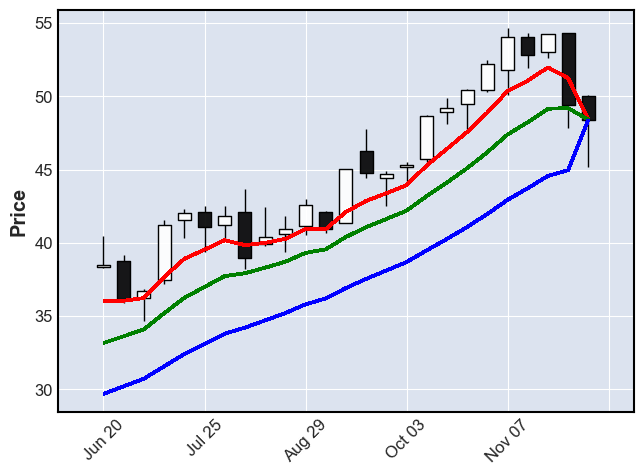

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit
In,,,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-20,-1.637501
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-27,-1.637501
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,nn,nn,2017-07-04,-1.637501
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,nn,nn,2017-07-11,-1.637501
4,41.582500,42.325001,40.325001,42.025002,38.908457,36.243407,32.403464,nn,nn,2017-07-18,-1.637501
5,42.097500,42.482498,39.389999,41.097500,39.533898,36.990191,33.098987,nn,nn,2017-07-25,-1.637501
6,41.235001,42.517502,40.154999,41.802502,40.182070,37.730546,33.795268,nn,nn,2017-08-01,-1.637501
7,42.097500,43.639999,38.227501,38.990002,39.841479,37.924309,34.210847,nn,nn,2017-08-08,-1.637501
8,39.917500,42.417500,39.799999,40.375000,39.993914,38.301338,34.703979,nn,nn,2017-08-15,-1.637501


In [485]:
import mplfinance as mpf
Dates = trades_df['Datetime']

if mover == 0 and switch == False:
    mover = 0
    print("Row start: ",mover) 
    print("Trade: ", 1)
    switch = True
else:
    mover += displayed_candles
    print("Row start: ",mover) 
    print("Trade: " + str(int(mover/displayed_candles)) + " (" + str(int(len(trades_df)/displayed_candles)) + ")") 

lower = mover
upper = mover + displayed_candles

selected_df = trades_df.iloc[lower:upper,:-1]
#print(selected_df)

#Get EMAs
dates = selected_df['Datetime']
ema6 = selected_df['ema6']
ema12 = selected_df['ema12']
ema24 = selected_df['ema24']
datepairs_ema6 = [(d1,d2) for d1,d2 in zip(dates,ema6)]
datepairs_ema12 = [(d1,d2) for d1,d2 in zip(dates,ema12)]
datepairs_ema24 = [(d1,d2) for d1,d2 in zip(dates,ema24)]
#datepairs_ema16

# #Format Dataframe
quotes = selected_df.iloc[:,:10]
quotes['Datetime'] = quotes['Datetime'].astype('datetime64')
quotes = quotes.set_index('Datetime')
quotes = quotes.iloc[:displayed_candles,:4]
quotes.columns=['open','high','low','close']

#Define function to get entry
EntryPriceRow = 0
def GetEntryPriceColl(candle):
    if candle == 'Previous High':
        EntryPriceColl = 1
        EntryPriceRow = 1
    if candle == 'Current Open':
        EntryPriceColl = 0
        EntryPriceRow = 0
    if candle == 'Previous Close':
        EntryPriceColl = 3
        EntryPriceRow = 1
    return EntryPriceColl, EntryPriceRow
entry_price_column,entry_price_row = GetEntryPriceColl(entry_candle)  #
# budget = 10000

entry = selected_df.iloc[window_size-1-entry_price_row,entry_price_column]
profit = selected_df.iloc[window_size-1,-1]
print(entry)
real_profit = round((budget / entry)*profit,2)
print("\nBudget: ",budget)

print("\nEntry price: ",round(entry,2))
print("Label (target): ",round(selected_df.iloc[window_size-1,7],2))
print("Model prediction: ",round(selected_df.iloc[window_size-1,8],2))
print("\nProfit: ",round(selected_df.iloc[window_size-1,-1],3))
print("Real Profit: " + str(real_profit) + " dollars (budget " + str(budget) + ")")

#two_points  = [('2018-07-31',48),('2018-08-01',49)]

mpf.plot(quotes,type='candle',alines=dict(alines=[datepairs_ema6,datepairs_ema12,datepairs_ema24],colors=['r','g','b'])) # datepairs_ema12,datepairs_ema24
#mpf.plot(quotes,type='candle')

selected_df

<b>Investigate losing trades</b>

In [486]:
selected_df

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit
In,,,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-20,-1.637501
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-27,-1.637501
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,nn,nn,2017-07-04,-1.637501
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,nn,nn,2017-07-11,-1.637501
4,41.582500,42.325001,40.325001,42.025002,38.908457,36.243407,32.403464,nn,nn,2017-07-18,-1.637501
5,42.097500,42.482498,39.389999,41.097500,39.533898,36.990191,33.098987,nn,nn,2017-07-25,-1.637501
6,41.235001,42.517502,40.154999,41.802502,40.182070,37.730546,33.795268,nn,nn,2017-08-01,-1.637501
7,42.097500,43.639999,38.227501,38.990002,39.841479,37.924309,34.210847,nn,nn,2017-08-08,-1.637501
8,39.917500,42.417500,39.799999,40.375000,39.993914,38.301338,34.703979,nn,nn,2017-08-15,-1.637501


In [487]:
trades_df.tail(30)

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
5970,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406,nn,nn,2022-05-31,0.070007,185
5971,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334,nn,nn,2022-06-07,0.070007,185
5972,160.000000,168.679993,153.279999,158.800003,176.168560,191.462513,210.243947,nn,nn,2022-06-14,0.070007,185
5973,164.750000,171.399994,158.529999,171.259995,174.766113,188.354434,207.125231,nn,nn,2022-06-21,0.070007,185
5974,173.119995,181.440002,140.550003,173.190002,167.075001,167.075001,167.075001,181.440002,192.548392,2022-06-22,0.070007,185
5975,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,2022-01-18,39.880005,186
5976,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,2022-01-25,39.880005,186
5977,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,2022-02-01,39.880005,186
5978,243.720001,269.250000,237.729996,239.490005,249.201020,258.308215,251.486399,nn,nn,2022-02-08,39.880005,186


In [488]:
raw_data = pd.read_csv('nvda_stock_raw_initial_df.csv')

In [489]:
losing_trades = trades_df[trades_df['profit']<0]
losing_trades

,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
In,,,,,,,,,,,,
0,38.352501,40.435001,38.305000,38.457500,36.011488,33.162876,29.691369,nn,nn,2017-06-20,-1.637501,1
1,38.790001,39.150002,35.875000,36.139999,36.048206,33.620895,30.207260,nn,nn,2017-06-27,-1.637501,1
2,36.262501,36.875000,34.645000,36.689999,36.231575,34.093064,30.725879,nn,nn,2017-07-04,-1.637501,1
3,37.435001,41.575001,37.169998,41.237499,37.661839,35.192208,31.566809,nn,nn,2017-07-11,-1.637501,1
4,41.582500,42.325001,40.325001,42.025002,38.908457,36.243407,32.403464,nn,nn,2017-07-18,-1.637501,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5945,162.740005,188.809998,157.800003,188.110001,188.972924,205.199624,221.361311,nn,nn,2022-05-24,-7.130005,184
5946,189.800003,196.190002,181.220001,187.199997,188.466373,202.430451,218.628406,nn,nn,2022-05-31,-7.130005,184
5947,191.389999,193.369995,168.690002,169.740005,183.115982,197.401152,214.717334,nn,nn,2022-06-07,-7.130005,184


In [490]:
loss_trade = raw_data[raw_data['Date'] > "2020-09-21"]
loss_trade.head(25)

,Unnamed: 0,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
1132,1132,2020-09-28,130.402496,137.627502,127.500000,130.622498,125.383554,118.524161,105.693309
1133,1133,2020-10-05,132.360001,141.419998,132.227493,137.627502,128.881825,121.463136,108.248045
1134,1134,2020-10-12,139.895004,143.485001,137.677505,138.115005,131.519877,124.024962,110.637402
1135,1135,2020-10-19,139.029999,139.835007,132.317505,135.902496,132.772054,125.852275,112.658609
1136,1136,2020-10-26,134.270004,136.927505,123.000000,125.339996,130.648609,125.773463,113.673120
1137,1137,2020-11-02,126.577499,145.887497,123.949997,145.619995,134.926148,128.826776,116.228870
1138,1138,2020-11-09,145.524994,146.914993,126.282501,132.970001,134.367249,129.464195,117.568161
1139,1139,2020-11-16,131.725006,136.494995,130.649994,130.877502,133.370178,129.681627,118.632908
1140,1140,2020-11-23,131.712494,134.074997,128.850006,132.612503,133.153700,130.132531,119.751276
1141,1141,2020-11-30,132.649994,136.735001,129.722504,135.582504,133.847644,130.970988,121.017774


<b>Create Report</b>

In [491]:
trades_df.to_csv('trades_df.csv')
trades_df = trades_df.reset_index()
#trades_df = trades_df.set_index('index')

try:
    trades_df = trades_df.drop('level_0',axis=1)
    trades_df = trades_df.drop('In',axis=1)
except:
    pass
trades_df.tail(20)

,In,opens,high,low,close,ema6,ema12,ema24,labels,prediction,Datetime,profit,Trades
4630,5980,230.350006,242.169998,208.899994,241.570007,244.412359,252.883752,249.584201,nn,nn,2022-02-22,39.880005,186
4631,5981,239.919998,246.649994,224.820007,229.360001,240.111685,249.264714,247.966265,nn,nn,2022-03-01,39.880005,186
4632,5982,228.169998,232.199997,206.500000,221.000000,234.651204,244.916296,245.808964,nn,nn,2022-03-08,39.880005,186
4633,5983,218.690002,265.690002,211.589996,264.529999,243.188002,247.933789,247.306646,nn,nn,2022-03-15,39.880005,186
4634,5984,265.070007,283.579987,255.750000,276.920013,252.825720,252.393208,249.675716,nn,nn,2022-03-22,39.880005,186
4635,5985,277.559998,289.459991,262.670013,267.119995,256.909798,254.658868,251.071258,nn,nn,2022-03-29,39.880005,186
4636,5986,267.279999,275.579987,230.619995,231.190002,249.561285,251.048273,249.480758,nn,nn,2022-04-05,39.880005,186
4637,5987,222.139999,227.770004,211.630005,212.580002,238.995204,245.130077,246.528697,nn,nn,2022-04-12,39.880005,186
4638,5988,212.000000,226.699997,195.000000,195.149994,226.468001,237.440834,242.418401,nn,nn,2022-04-19,39.880005,186
4639,5989,192.020004,201.279999,182.899994,185.470001,214.754287,229.445321,237.862529,nn,nn,2022-04-26,39.880005,186


In [492]:
try:
    raw_data = raw_data.drop('Unnamed: 0',axis=1)
except:
    pass
raw_data

,Date,Open,High,Low,Close,EMA6,EMA12,EMA24
0,1999-01-18,0.437500,0.488281,0.388021,0.410156,NaN,NaN,NaN
1,1999-01-25,0.442708,0.467448,0.395833,0.395833,NaN,NaN,NaN
2,1999-02-01,0.395833,0.416667,0.360677,0.412760,NaN,NaN,NaN
3,1999-02-08,0.415365,0.437500,0.372396,0.434896,NaN,NaN,NaN
4,1999-02-15,0.442708,0.460938,0.393229,0.434896,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
1224,2022-07-04,141.750000,160.369995,140.550003,158.380005,164.056589,178.129151,198.670124
1225,2022-07-11,155.259995,157.820007,144.649994,157.619995,162.217562,174.973896,195.386113
1226,2022-07-18,163.020004,181.440002,160.020004,173.190002,165.352545,174.699451,193.610424
1227,2022-07-25,170.190002,182.440002,164.779999,181.630005,170.003248,175.765690,192.651991


In [493]:
trades_df.head()
entry_candle

'Current Open'

In [494]:
performance_report = trades_df.copy()

# def Get_hold_period(df,date_from,profit):
#     period = 0
    
#     if profit < 0:
#         condition = df['Date'] == date_from
#         sorted_df = df[condition]
#         print(sorted_df)
#         st_temp = sorted_df.reset_index()
#         first_boundary = st_temp.loc[0,'index']
#         c = 0
#         period = 0
#         while c < 5:
#             c += 1
#             print(raw_data.loc[first_boundary+c,'High'])
#             target = raw_data.loc[first_boundary+c,'High']

#             if target != entry:
#                 period = c
#                 break

#     return period

def profit_calculation(difference,stock_price,budget):
    qty = round(budget/stock_price,0)
    
    return round(difference * qty)

EntryPriceRow = 0
def GetEntryPriceColl(candle):
    if candle == 'Previous High':
        EntryPriceColl = 'high'
        EntryPriceRow = 1
    if candle == 'Current Open':
        EntryPriceColl = 'opens'
        EntryPriceRow = 0
    if candle == 'Previous Close':
        EntryPriceColl = 'close'
        EntryPriceRow = 1
    return EntryPriceColl, EntryPriceRow

entry_coll, entry_row = GetEntryPriceColl(entry_candle) #

budget = 10000

for row in range(24,len(performance_report),25):
    #Get data items
    #print(row)
    #print(performance_report.loc[row-1,'high'])
    entry = performance_report.loc[row-entry_row,entry_coll]
    difference = performance_report.loc[row,'profit']
    prediction = performance_report.loc[row,'prediction']
    ent_date = performance_report.loc[row-1,'Datetime']
    
    #Fill data
    performance_report.loc[row,'Entry'] = entry
    performance_report.loc[row,'Performance'] = profit_calculation(difference,entry,budget)
    #performance_report.loc[row,'Holding period'] = Get_hold_period(raw_data,ent_date,difference)
    
performance_report = performance_report.fillna("nn")

<b>Reorder columns</b>

In [495]:
performance_report = performance_report[['Datetime', 'opens', 'high', 'low','close','ema6','ema12','ema24','Entry','labels','prediction','profit','Performance','Trades']]

In [496]:
performance_report.tail(26)

,Datetime,opens,high,low,close,ema6,ema12,ema24,Entry,labels,prediction,profit,Performance,Trades
4624,2022-06-22,173.119995,181.440002,140.550003,173.190002,167.075001,167.075001,167.075001,173.119995,181.440002,192.548392,0.070007,4.0,185
4625,2022-01-18,262.600006,266.380005,232.630005,233.740005,268.501034,271.773393,255.510544,nn,nn,nn,39.880005,nn,186
4626,2022-01-25,223.300003,240.570007,208.880005,228.399994,257.043594,265.100563,253.341700,nn,nn,nn,39.880005,nn,186
4627,2022-02-01,231.820007,258.170013,230.520004,243.190002,253.085425,261.729707,252.529564,nn,nn,nn,39.880005,nn,186
4628,2022-02-08,243.720001,269.250000,237.729996,239.490005,249.201020,258.308215,251.486399,nn,nn,nn,39.880005,nn,186
4629,2022-02-15,239.339996,265.820007,231.000000,236.419998,245.549299,254.940797,250.281087,nn,nn,nn,39.880005,nn,186
4630,2022-02-22,230.350006,242.169998,208.899994,241.570007,244.412359,252.883752,249.584201,nn,nn,nn,39.880005,nn,186
4631,2022-03-01,239.919998,246.649994,224.820007,229.360001,240.111685,249.264714,247.966265,nn,nn,nn,39.880005,nn,186
4632,2022-03-08,228.169998,232.199997,206.500000,221.000000,234.651204,244.916296,245.808964,nn,nn,nn,39.880005,nn,186
4633,2022-03-15,218.690002,265.690002,211.589996,264.529999,243.188002,247.933789,247.306646,nn,nn,nn,39.880005,nn,186


In [497]:
# performance_report.to_csv('nvda_80_performance_report.csv')

In [498]:
performance_report.to_excel('nvda_80_performance_report.xlsx')